# River Network Simulator
A fast algorithm for randomly generating river networks.

## Motivation
This project grew out of my frustration with procedural terrain generators which are typically some variation on the "Perlin Hills." This is a bit ironic since Ken Perlin developed his eponymous algorithm because of ["his frustration with the 'machine-like' look of computer-generated imagery."](https://en.wikipedia.org/wiki/Perlin_noise)

After spending far too long idly browsing Google Earth, I noticed that the topography of most regions is primarily defined by river basins, even relatively dry biomes. So, it seemed that to create more natural-looking procedurally generated terrain, a natural first step would be to find a fast method for simulating river networks. 

## Approach
A conceptual sketch of the algorithm is:
1. Generate a random set of (2D) points.
2. Find the Delaunay triangulation.
3. Assign each node a height according to some (fast, well-behaved) function.
4. Sort the nodes in descending order of height. Use this as a check queue.
5. At each node, find the initial current (momentum) as the (3-vector) sum of all incoming currents, plus a current of mass 1 and initial velocity 0 (the contribution from the current node).
6. At each node, $n_0$, find the neighboring node, $n_i$ with the shortest $\Delta t$, where $\Delta t$ is the time to slide without friction down the straight slope from $n_0$ to $n_i$. Initial (vector) velocity is determined from step 5. 
7. Pass the outgoing momentum to the downstream node.
8. If the downstream node is uphill (higher z), jump out of the check queue and recheck any changed nodes.

## Assumptions and Simplifications
1. The 2D Delaunay triangulation is used to define nearest neighbors, which implicitly assumes that the height function is sufficiently smooth so that the region encompassing a node and all of its neighbors is approximately planar.
2. All nodes are treated as having the same catchment. That is, the volume (mass) of water added to a stream at each node is equal.
3. No consideration is given to non-conservative forces such as friction or viscosity. Although, some effective energy loss happens at each node from a. adding a small amount of mass at zero velocity and b. being restricted to move along a triangulation edge.
4. No consideration is given to mass transport, that is erosion of material upstream that is later deposited downstream.
5. No iteration is done to simulate stream migration or historical flows, besides resolving corrections for uphill flows.

## Comments
* The width of a line in the plot is proportional to the square root of the mass per length of the water transported along that node, which is a simplest approximation for the width of the river surface. Cube root or log weighting does a nice job of enhancing smaller streams.
* I haven't properly benchmarked it yet, but it involves two $n \log(n)$ processes -- Delaunay triangulation and sorting -- and those seem to be dominating the complexity scaling.
* The results are qualitatively very similar to [real world river networks](https://nelsonslog.files.wordpress.com/2013/05/ms.jpg).

## Next Steps
1. Clean up my slop-code and make it more objective. I'm currently using the NetworkX framework to store node and edge data, but it would be better for nodes, edges, and proabably simplices (and the whole graph) to be true objects that can own their relevant methods. 
2. Possibly translate to another language that's better suited for 3D rendering (C++/C#).
3. Adjust river heights/slopes and interpolate ridges between them. This is tricky, but I have some ideas of how to approach it.
4. Write an algorithm for simulating mountains and valleys created by tectonics and vulcanism (in an extremely simplified way) to use for the initial elevation.

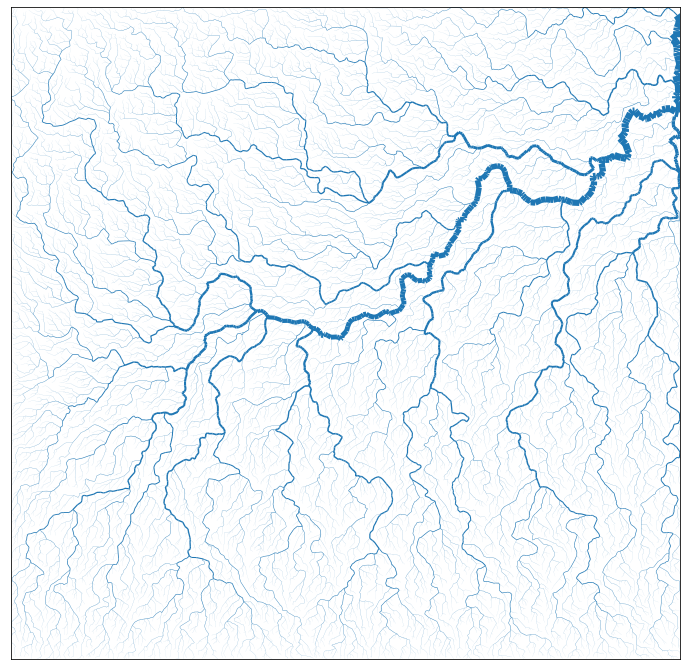

4.166895389556885


In [1174]:
import numpy as np
import networkx as nx
from scipy.spatial import Delaunay, ConvexHull
from matplotlib import pyplot as plt
import time

npts = 40000
np.random.seed(68648)

#Make the generation of nodes and potential coefficients independent from each other.
seed1, seed2 = np.random.randint(2**31,size=2)

def V(x,y):
    """
    V because it's like a potential.
    """
    def polyV(deg):
        f = 0
        for n in range(deg+1):
            for m in range(deg+1):
                coeff = 2*np.random.random_sample()-1
                f += coeff*x**n*y**m/(n+m+1)
        return f
    
    def polesV(num):
        f = 1
        for n in range(num):
            coeff = 2*np.random.random_sample((4))-1
            f += coeff[0]/(1+coeff[1]+np.sqrt((x-2*coeff[2]+0.5)**2+(y-2*coeff[3]+0.5)**2))
        return f
    
    return polyV(4)

np.random.seed(seed1)
pts = np.random.random_sample((npts,2))
np.random.seed(seed2)
zs = np.array((V(pts[:,0],pts[:,1])))

def pts3d(i):
    return (pts[i][0],pts[i][1],zs[i])

start = time.time()

#For debugging
#labelset = set()

def rivernetwork(points,heights):
    flowq = list((-heights).argsort())
    qtop = flowq[0]
    qend = flowq[-1]
    global rechecks
    rechecks = []
    visited = []
    vetos = []
    
    deltri = Delaunay(points)
    hull = ConvexHull(points)
    gr = nx.DiGraph()
    def neighbors(i):
        return deltri.vertex_neighbor_vertices[1]\
            [deltri.vertex_neighbor_vertices[0][i]:deltri.vertex_neighbor_vertices[0][i+1]]

    def flowrate(p1,p2,vel=(0.,0.,0.)):
        x = points[p2][0]-points[p1][0]
        y = points[p2][1]-points[p1][1]
        z = heights[p2]-heights[p1]
        r = np.sqrt(x*x+y*y+z*z)
        vi = (x*vel[0]+y*vel[1]+z*vel[2])/r
        vfsq = vi**2-2*z
        vf = (0,0,0)
        dt = -np.inf
        if vfsq >= 0:
            dt = (vi+np.sqrt(vfsq))/(2*r)
            vhat = np.sqrt(vfsq)/r
            vf = (vhat*x,vhat*y,vhat*z)
        return dt, vf    

    def findoutflow(pt,veto=[],vetouphill=False):       
        px = py = pz = 0
        m = 1
        for pred in gr.predecessors(pt):
            pxi,pyi,pzi = gr.edges[pred,pt]['outflow']
            mass = gr.edges[pred,pt]['weight']
            px += pxi
            py += pyi
            pz += pzi
            m += mass
            if pred in gr.successors(pt) and gr.edges[pred,pt]['weight'] > gr.edges[pt,pred]['weight']:
                px -= gr.edges[pt,pred]['outflow'][0]
                py -= gr.edges[pt,pred]['outflow'][1]
                pz -= gr.edges[pt,pred]['outflow'][2]
                m -= gr.edges[pt,pred]['weight']
        vi = (px/m,py/m,pz/m)
        dtmax = 0
        vf = (0.,0.,0.) 
        nbrmax = None
        for nbr in neighbors(pt):
            if veto and nbr in veto:
                continue
            if vetouphill and heights[nbr] > heights[pt]:
                continue
            dt, vn = flowrate(pt,nbr,vi)
            if dt > dtmax:
                dtmax = dt
                vf = vn
                nbrmax = nbr       
        outflow = tuple(v*m for v in vf)
        return nbrmax, outflow, m

    while flowq:        
        if rechecks:
            rechecks = sorted(set(rechecks), key=lambda i: heights[i], reverse=True)
            thisnode = rechecks.pop(0)
        else:
            thisnode = flowq.pop(0)
            if flowq:
                qtop = flowq[0]
            vetos = []
            visited = []
            gr.add_node(thisnode, pos=(points[thisnode][0],points[thisnode][1]))
        if thisnode in visited:
            for pred in gr.predecessors(thisnode):
                if pred in visited and heights[pred] > heights[thisnode]:
                    vetos += [pred]
        oldouts = list(gr.successors(thisnode))
        nextnode, p_out, m = findoutflow(thisnode,veto=vetos)
        for oldout in oldouts:
            gr.remove_edge(thisnode,oldout)
            if heights[oldout] > heights[qtop]:
                rechecks += [oldout]
        visited += [thisnode]
        if nextnode == None:
            if thisnode in hull.vertices and len(list(gr.predecessors(thisnode))):
                continue
            else: #Kludged in
                dtmax = -np.inf
                vf = (0,0,0)
                nmax = None
                for n in neighbors(thisnode):
                    if heights[n] < heights[thisnode]:
                        dt, vout = flowrate(thisnode,n)
                        if dt > dtmax:
                            dtmax = dt
                            vf = vout
                            nmax = n
                if nmax != None:
                    outfl = tuple(v*m for v in vf)
                    gr.add_edge(thisnode,nmax,outflow=outfl,weight=m)                
        else:
            gr.add_edge(thisnode,nextnode,outflow=p_out,weight=m)
            if heights[nextnode] > heights[qtop]:
                rechecks += [nextnode]
    return gr
    
flowgraph = rivernetwork(pts,zs)

end = time.time()

fig, ax = plt.subplots(figsize=(12,12))            
pos = nx.get_node_attributes(flowgraph,'pos')
widths = np.sqrt(list(nx.get_edge_attributes(flowgraph,'weight').values()))/np.sqrt(npts)*8
#widths = np.cbrt(list(nx.get_edge_attributes(flowgraph,'weight').values()))/np.cbrt(npts)*12
#widths = np.log2(list(nx.get_edge_attributes(flowgraph,'weight').values()))/np.log2(npts)*4
nx.draw_networkx_edges(flowgraph,pos,width=widths,edge_color='C0',arrows=False) 
#retri = Delaunay(pts)
#plt.triplot(pts[:,0], pts[:,1], retri.simplices,color='#00000040',linewidth=0.5)
for x,y,p in zip(pts[:,0],pts[:,1],range(npts)):
    if p in labelset:
        label = "{0}".format(p)
        plt.annotate(label, (x,y), textcoords="offset points", xytext=(0,0), ha='center')
plt.xticks([])
plt.yticks([])
plt.axis([0, 1, 0, 1])
plt.show()

print(end-start)